# 4. 按月份统计每个月论文的提交数量

In [3]:
import pandas as pd

df_all = pd.read_pickle('../../arxiv-metadata-oai-2019.pkl')
df_all

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,group
0,0704.0297,Sung-Chul Yoon,"Sung-Chul Yoon, Philipp Podsiadlowski and Step...",Remnant evolution after a carbon-oxygen white ...,"15 pages, 15 figures, 3 tables, submitted to M...",None,10.1111/j.1365-2966.2007.12161.x,None,astro-ph,None,We systematically explore the evolution of t...,"[{'version': 'v1', 'created': 'Tue, 3 Apr 2007...",2019-08-19,"[[Yoon, Sung-Chul, ], [Podsiadlowski, Philipp,...",Physics
1,0704.0342,Patrice Ntumba Pungu,B. Dugmore and PP. Ntumba,Cofibrations in the Category of Frolicher Spac...,27 pages,None,None,None,math.AT,None,Cofibrations are defined in the category of ...,"[{'version': 'v1', 'created': 'Tue, 3 Apr 2007...",2019-08-19,"[[Dugmore, B., ], [Ntumba, PP., ]]",Mathematics
2,0704.0360,Zaqarashvili,T.V. Zaqarashvili and K Murawski,Torsional oscillations of longitudinally inhom...,"6 pages, 3 figures, accepted in A&A",None,10.1051/0004-6361:20077246,None,astro-ph,None,We explore the effect of an inhomogeneous ma...,"[{'version': 'v1', 'created': 'Tue, 3 Apr 2007...",2019-08-19,"[[Zaqarashvili, T. V., ], [Murawski, K, ]]",Physics
3,0704.0525,"Sezgin Ayg\""un","Sezgin Aygun, Ismail Tarhan, Husnu Baysal",On the Energy-Momentum Problem in Static Einst...,This submission has been withdrawn by arXiv ad...,"Chin.Phys.Lett.24:355-358,2007",10.1088/0256-307X/24/2/015,None,gr-qc,None,This paper has been removed by arXiv adminis...,"[{'version': 'v1', 'created': 'Wed, 4 Apr 2007...",2019-10-21,"[[Aygun, Sezgin, ], [Tarhan, Ismail, ], [Baysa...",Physics
4,0704.0535,Antonio Pipino,"Antonio Pipino (1,3), Thomas H. Puzia (2,4), a...",The Formation of Globular Cluster Systems in M...,"32 pages (referee format), 9 figures, ApJ acce...","Astrophys.J.665:295-305,2007",10.1086/519546,None,astro-ph,None,The most massive elliptical galaxies show a ...,"[{'version': 'v1', 'created': 'Wed, 4 Apr 2007...",2019-08-19,"[[Pipino, Antonio, ], [Puzia, Thomas H., ], [M...",Physics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170613,quant-ph/9904032,Mikhail Lukin,"V. A. Sautenkov, M. D. Lukin, C. J. Bednar, G....",Enhancement of Magneto-Optic Effects via Large...,None,None,10.1103/PhysRevA.62.023810,None,quant-ph,None,We utilize the generation of large atomic co...,"[{'version': 'v1', 'created': 'Thu, 8 Apr 1999...",2019-08-17,"[[Sautenkov, V. A., ], [Lukin, M. D., ], [Bedn...",Physics
170614,solv-int/9511005,Wen-Xiu Ma,"Wen-Xiu Ma, Benno Fuchssteiner",Explicit and Exact Solutions to a Kolmogorov-P...,"14pages, Latex, to appear in Intern. J. Nonlin...",None,10.1016/0020-7462(95)00064-X,None,solv-int nlin.SI,None,Some explicit traveling wave solutions to a ...,"[{'version': 'v1', 'created': 'Tue, 14 Nov 199...",2019-08-15,"[[Ma, Wen-Xiu, ], [Fuchssteiner, Benno, ]]",Physics
170615,solv-int/9809008,Victor Enolskii,"J C Eilbeck, V Z Enol'skii, V B Kuznetsov, D V...",Linear r-Matrix Algebra for a Hierarchy of One...,"plain LaTeX, 28 pages",None,None,None,solv-int nlin.SI,None,We consider a hierarchy of many-particle sys...,"[{'version': 'v1', 'created': 'Wed, 2 Sep 1998...",2019-08-17,"[[Eilbeck, J C, ], [Enol'skii, V Z, ], [Kuznet...",Physics
170616,solv-int/9909010,Pierre van Moerbeke,"M. Adler, T. Shiota and P. van Moerbeke",Pfaff tau-functions,42 pages,None,None,None,solv-int adap-org hep-th nlin.AO nlin.SI,None,Consider the evolution $$ \frac{\pl m_\iy}{\...,"[{'version': 'v1', 'created': 'Wed, 15 Sep 199...",2019-08-17,"[[Adler, M., ], [Shiota, T., ], [van Moerbeke,...",Physics


<AxesSubplot:xlabel='Month'>

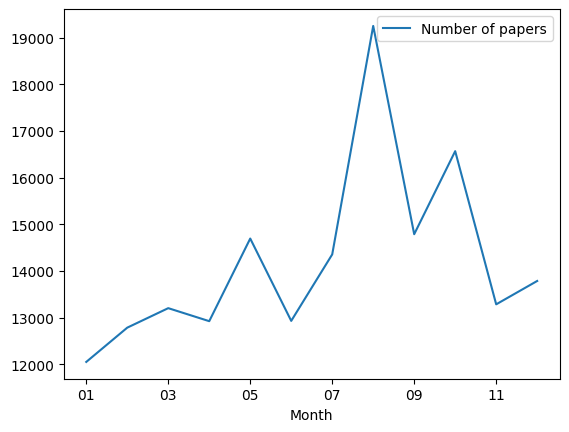

In [4]:
df_all['Month'] = df_all['update_date'].map(lambda x: x.split('-')[1])
df_all['Month'].astype(int)
df_all.groupby('Month').size().to_frame('Number of papers').plot()

# 5、作者关系网（最大连通图）以及 相关信息

In [5]:
import networkx as nx


# 根据给的论文大类提取相关数据
def queryBycategrot(data, categrot):
    return data[data['group'].str.contains(categrot)]


group_name = ['Computer Science', 'Economics', 'Electrical Engineering and Systems Science',
              'Mathematics', 'Physics', 'Quantitative Biology', 'Quantitative Finance', 'Statistics']
gr_author_dic = {'Group': [], 'Nodes': [], 'Edges': [], 'Author': [], 'Collaborators': []}
for group in group_name:
    group_df = queryBycategrot(df_all, group)
    # ~ 表示取反
    group_df = group_df[~ group_df['submitter'].isnull()]
    # 创建网络
    G = nx.Graph()
    for row in group_df.itertuples():
        submitter = row.submitter
        authors = row.authors_parsed
        authors = [' '.join(reversed(au)) for au in authors]
        for i in authors:
            if i != submitter:
                G.add_edge(submitter, i)
    C = sorted(nx.connected_components(G), key=len, reverse=True)
    sub_G = G.subgraph(C[0])
    gr_author_dic['Group'].append(group)
    gr_author_dic['Nodes'].append(len(sub_G.nodes))
    gr_author_dic['Edges'].append(len(sub_G.edges))
    gr_author_dic['Author'].append(max(sub_G.degree, key=lambda x: x[1])[0])
    gr_author_dic['Collaborators'].append(max(sub_G.degree, key=lambda x: x[1])[1])
    gr_author_df = pd.DataFrame(gr_author_dic)
gr_author_df.to_csv('../output/auther.csv', index=False)
gr_author_df

,Group,Nodes,Edges,Author,Collaborators
0,Computer Science,95904,124613,EPTCS,535
1,Economics,72,82,Ivan Fernandez-Val,16
2,Electrical Engineering and Systems Science,9831,11446,Kong Aik Lee,46
3,Mathematics,43656,49849,Thorsten Wissmann,42
4,Physics,205224,387320,LVC Publications,2994
5,Quantitative Biology,158,166,Jianhua Xing,19
6,Quantitative Finance,87,95,Antoine Jacquier Dr.,9
7,Statistics,25425,30223,Spyridon Bakas,424


# 6、获取每类中论文数量前10的作者

In [6]:
auther_dic = {}
author_pages_dic = {'auther': [], 'amount': []}
# 以 Physics 举例
group_df = queryBycategrot(df_all, 'Physics')
for row in group_df.itertuples():
    authors = row.authors_parsed
    authors = [' '.join(reversed(au)) for au in authors]
    for i in authors:
        if auther_dic.get(i):
            auther_dic[i] += 1
        else:
            auther_dic[i] = 1
for au in auther_dic:
    author_pages_dic['auther'].append(au)
    author_pages_dic['amount'].append(auther_dic[au])
auther_pages_df = pd.DataFrame(author_pages_dic)
auther_pages_df.sort_values('amount', ascending=False).head(10)

,auther,amount
16568,Y. Wang,190
24105,Y. Zhang,186
5312,X. Li,167
24103,L. Zhang,152
24402,X. Liu,151
24506,Z. Wang,148
20008,Kenji Watanabe,138
20007,Takashi Taniguchi,138
23989,L. Sun,136
9761,J. Zhang,134
